In [4]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
! pip install pandas sqlalchemy psycopg2-binary seaborn matplotlib ftfy




[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
# --- Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from ftfy import fix_text

# Pretty plots
sns.set(style="whitegrid", palette="muted", font_scale=1.05)

# --- DB credentials (EDIT THESE)
USER     = "postgres"
PASSWORD = "2024"
HOST     = "localhost"     # or server IP
PORT     = "5432"
DBNAME   = "real"
TABLE    = "combine"      # or your materialized/cleaned table name

# --- Connect & load
engine = create_engine(f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DBNAME}")
df = pd.read_sql(f'SELECT * FROM "{TABLE}";', engine)

print("Shape:", df.shape)
df.head()


Shape: (19983, 23)


,id,source,title,price,location,description,surface,rooms,bedrooms,bathrooms,...,image_url,published_time,terrace,garage,elevator,concierge,pool,security,garden,insert_date
0,1,mubawab,Rent an apartment. Dimension 91 m². Furnished,4700.0,"Chefchaouen, Chefchaouen",Rent an apartment. Dimension 91 m². Furnished,91.0,4.0,3.0,2.0,...,https://www.mubawab-media.com/ad/8/192/050F/h/...,None,False,False,True,False,False,False,False,2025-08-21 15:11:03.574041
1,2,mubawab,Very nice apartment for rent in Guéliz. 2 room...,18000.0,"Guéliz, Marrakech",Very nice apartment for rent in Guéliz. 2 room...,100.0,3.0,2.0,2.0,...,https://www.mubawab-media.com/ad/8/190/569F/h/...,None,True,True,True,False,False,False,False,2025-08-21 15:11:03.574105
2,3,mubawab,Rent an apartment in Ferme Bretonne Hay Arraha...,10000.0,"Ferme Bretonne (Hay Arraha), Casablanca",Rent an apartment in Ferme Bretonne Hay Arraha...,100.0,3.0,2.0,2.0,...,https://www.mubawab-media.com/ad/8/190/169F/h/...,None,True,True,True,True,False,False,False,2025-08-21 15:11:03.574130
3,4,mubawab,Lovely apartment for rent in Anfa. Total area ...,19000.0,"Anfa, Casablanca",Lovely apartment for rent in Anfa. Total area ...,150.0,4.0,3.0,3.0,...,https://www.mubawab-media.com/ad/8/189/512F/h/...,None,True,True,True,True,False,False,False,2025-08-21 15:11:03.574148
4,5,mubawab,Lovely apartment for rent in Route de l'Ourika...,6800.0,"Route de l'Ourika, Marrakech",Lovely apartment for rent in Route de l'Ourika...,70.0,2.0,1.0,1.0,...,https://www.mubawab-media.com/ad/8/189/080F/h/...,None,True,True,False,False,False,False,True,2025-08-21 15:11:03.574165


In [9]:
# Keep an original copy
raw = df.copy()

# Standardize column names
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Quick info
print(df.dtypes)
print("\nMissing values:\n", df.isna().sum())

# --- Fix encodings in text columns (title, description, location)
for col in ["title", "description", "location", "property_category", "type", "source"]:
    if col in df.columns:
        df[col] = df[col].astype(str).map(lambda x: None if x.lower() in ["none", "nan", "null"] else x)
        df[col] = df[col].dropna().map(fix_text).reindex(df.index)

# --- Convert numerics
for col in ["price", "surface", "rooms", "bedrooms", "bathrooms"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# --- Convert booleans (they may be strings "True"/"False")
bool_cols = ["terrace","garage","elevator","concierge","pool","security","garden"]
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].map({True: True, False: False, "True": True, "False": False, "true": True, "false": False})
        df[col] = df[col].astype("boolean")

# --- Datetimes
for col in ["published_time", "insert_date"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

print("\nDtypes after cleaning:\n", df.dtypes)
print("\nRemaining nulls:\n", df.isna().sum())


id                            int64
source                       object
title                        object
price                       float64
location                     object
description                  object
surface                     float64
rooms                       float64
bedrooms                    float64
bathrooms                   float64
type                         object
property_category            object
link                         object
image_url                    object
published_time               object
terrace                        bool
garage                         bool
elevator                       bool
concierge                      bool
pool                           bool
security                       bool
garden                         bool
insert_date          datetime64[ns]
dtype: object

Missing values:
 id                       0
source                   0
title                    0
price                    0
location                 0
descr

C:\Users\elbah\AppData\Local\Temp\ipykernel_28124\759439616.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors="coerce")


In [10]:
# Location format example: "Guéliz, Marrakech" or "Anfa, Casablanca"
def split_location(loc):
    if not isinstance(loc, str) or not loc.strip():
        return pd.Series({"district": None, "city": None})
    parts = [p.strip() for p in loc.split(",")]
    if len(parts) == 1:
        return pd.Series({"district": None, "city": parts[0]})
    return pd.Series({"district": parts[0], "city": parts[-1]})

if "location" in df.columns:
    loc_df = df["location"].apply(split_location)
    df = pd.concat([df, loc_df], axis=1)

# Price per m²
if {"price","surface"}.issubset(df.columns):
    df["price_per_m2"] = df["price"] / df["surface"]

# Temporal features (from published_time if present)
if "published_time" in df.columns:
    df["pub_year"]  = df["published_time"].dt.year
    df["pub_month"] = df["published_time"].dt.month
    df["pub_week"]  = df["published_time"].dt.isocalendar().week.astype("Int64")

# Simple NLP signal: furnished flag from title/description
def contains(word, text):
    if not isinstance(text, str): return False
    return word.lower() in text.lower()



df.head(3)


,id,source,title,price,location,description,surface,rooms,bedrooms,bathrooms,...,security,garden,insert_date,district,city,price_per_m2,pub_year,pub_month,pub_week,is_furnished
0,1,mubawab,Rent an apartment. Dimension 91 m². Furnished,4700.0,"Chefchaouen, Chefchaouen",Rent an apartment. Dimension 91 m². Furnished,91.0,4.0,3.0,2.0,...,False,False,2025-08-21 15:11:03.574041,Chefchaouen,Chefchaouen,51.648352,NaN,NaN,<NA>,True
1,2,mubawab,Very nice apartment for rent in Guéliz. 2 room...,18000.0,"Guéliz, Marrakech",Very nice apartment for rent in Guéliz. 2 room...,100.0,3.0,2.0,2.0,...,False,False,2025-08-21 15:11:03.574105,Guéliz,Marrakech,180.000000,NaN,NaN,<NA>,False
2,3,mubawab,Rent an apartment in Ferme Bretonne Hay Arraha...,10000.0,"Ferme Bretonne (Hay Arraha), Casablanca",Rent an apartment in Ferme Bretonne Hay Arraha...,100.0,3.0,2.0,2.0,...,False,False,2025-08-21 15:11:03.574130,Ferme Bretonne (Hay Arraha),Casablanca,100.000000,NaN,NaN,<NA>,False


In [11]:
print("Rows:", len(df))
print("\nBy source:\n", df["source"].value_counts(dropna=False).head(10))
if "type" in df:
    print("\nBy type (For Rent/Sale):\n", df["type"].value_counts(dropna=False))

num_cols = ["price","surface","rooms","bedrooms","bathrooms","price_per_m2"]
display(df[num_cols].describe().T)

if "city" in df:
    print("\nTop cities:\n", df["city"].value_counts().head(15))


Rows: 19983

By source:
 source
avito      15376
mubawab     4607
Name: count, dtype: int64

By type (For Rent/Sale):
 type
For Rent    10069
For Sale     9914
Name: count, dtype: int64


,count,mean,std,min,25%,50%,75%,max
price,19983.0,673300.064054,1.220138e+06,200.00000,5900.000000,25000.000000,920000.000000,13200000.0
surface,19983.0,104.997848,8.789514e+01,6.00000,65.000000,87.000000,115.000000,2385.0
rooms,19930.0,2.585650,1.381554e+00,1.00000,2.000000,2.000000,3.000000,12.0
bedrooms,19850.0,2.282166,9.571553e-01,1.00000,2.000000,2.000000,3.000000,11.0
bathrooms,19715.0,1.611210,8.044881e-01,0.00000,1.000000,1.000000,2.000000,8.0
price_per_m2,19983.0,5954.085073,9.208530e+03,1.73913,69.444444,178.571429,9777.777778,350000.0



Top cities:
 city
Toute la ville    1845
Casablanca        1732
Autre secteur     1205
Marrakech          800
Tanger             758
Oulfa              663
Agdal              485
Ain Sebaa          367
Maarif             359
Mohammédia         275
Guéliz             260
Centre Ville       256
Belvédère          246
Sidi Maarouf       221
Aïn Chock          215
Name: count, dtype: int64


In [12]:
def clip_series(s, lower_q=0.01, upper_q=0.99):
    lo, hi = s.quantile(lower_q), s.quantile(upper_q)
    return s.clip(lower=lo, upper=hi)

df["_price_clip"]        = clip_series(df["price"].dropna()) if "price" in df else np.nan
df["_surface_clip"]      = clip_series(df["surface"].dropna()) if "surface" in df else np.nan
df["_ppm2_clip"]         = clip_series(df["price_per_m2"].dropna()) if "price_per_m2" in df else np.nan


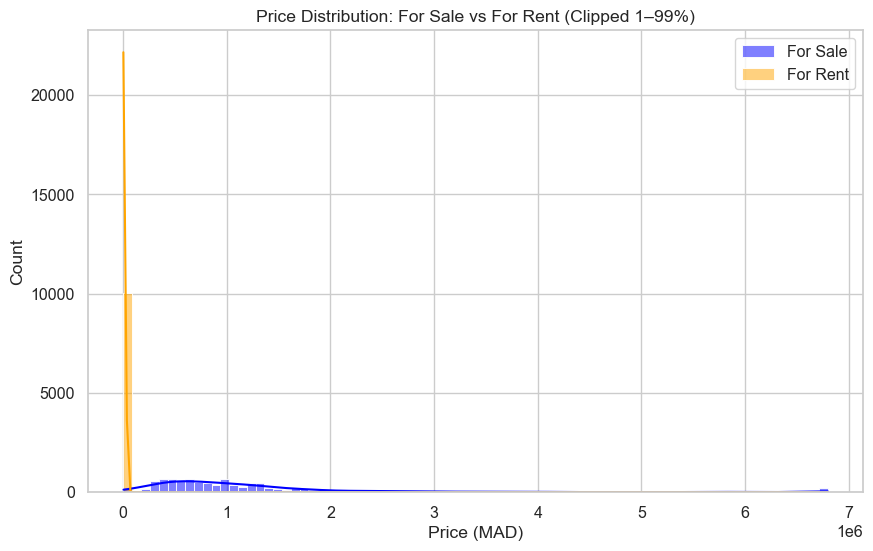

In [22]:
plt.figure(figsize=(10,6))

# Plot two histograms, one for "For Sale" and one for "For Rent"
sns.histplot(
    data=df[df["type"] == "For Sale"], 
    x="_price_clip", 
    bins=80, 
    kde=True, 
    color="blue", 
    label="For Sale", 
    alpha=0.5
)

sns.histplot(
    data=df[df["type"] == "For Rent"], 
    x="_price_clip", 
    bins=80, 
    kde=True, 
    color="orange", 
    label="For Rent", 
    alpha=0.5
)

plt.title("Price Distribution: For Sale vs For Rent (Clipped 1–99%)")
plt.xlabel("Price (MAD)")
plt.ylabel("Count")
plt.legend()
plt.show()


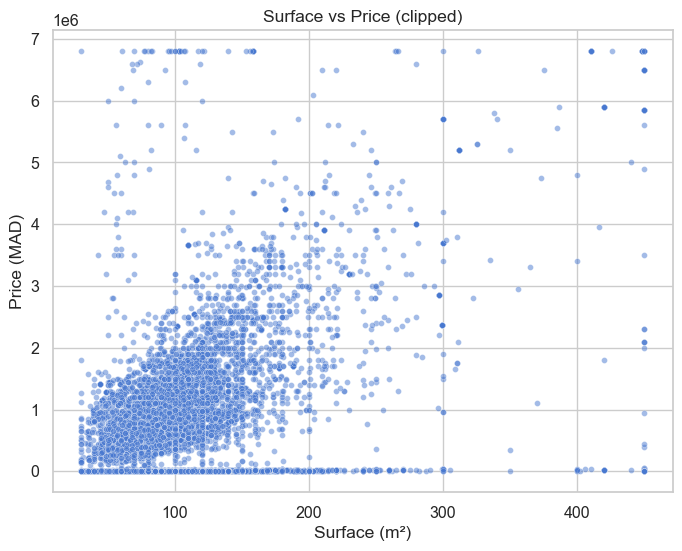

In [14]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="_surface_clip", y="_price_clip", data=df, s=18, alpha=0.5)
plt.title("Surface vs Price (clipped)")
plt.xlabel("Surface (m²)")
plt.ylabel("Price (MAD)")
plt.show()


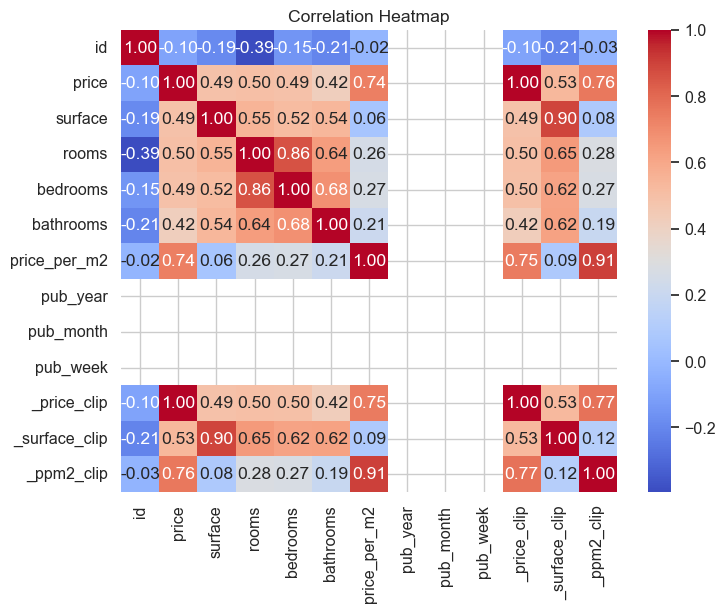

In [15]:
plt.figure(figsize=(8,6))
corr = df.select_dtypes(include=[np.number]).corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


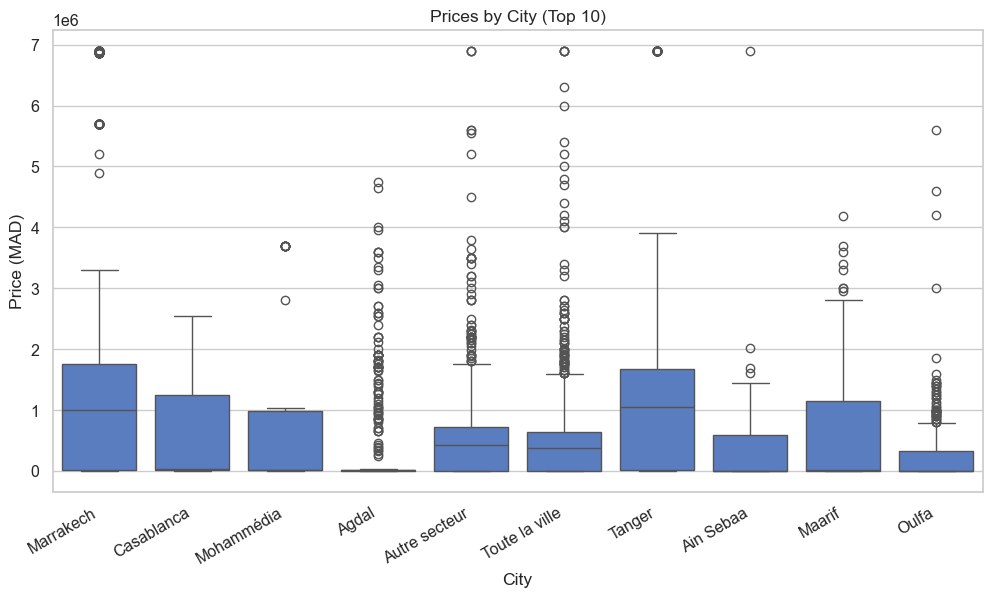

In [16]:
TOP_N = 10
if "city" in df.columns:
    top_cities = df["city"].value_counts().head(TOP_N).index
    subset = df[df["city"].isin(top_cities)].copy()
    subset["_price_clip"] = clip_series(subset["price"])
    
    plt.figure(figsize=(12,6))
    sns.boxplot(data=subset, x="city", y="_price_clip")
    plt.title(f"Prices by City (Top {TOP_N})")
    plt.xlabel("City")
    plt.ylabel("Price (MAD)")
    plt.xticks(rotation=30, ha="right")
    plt.show()


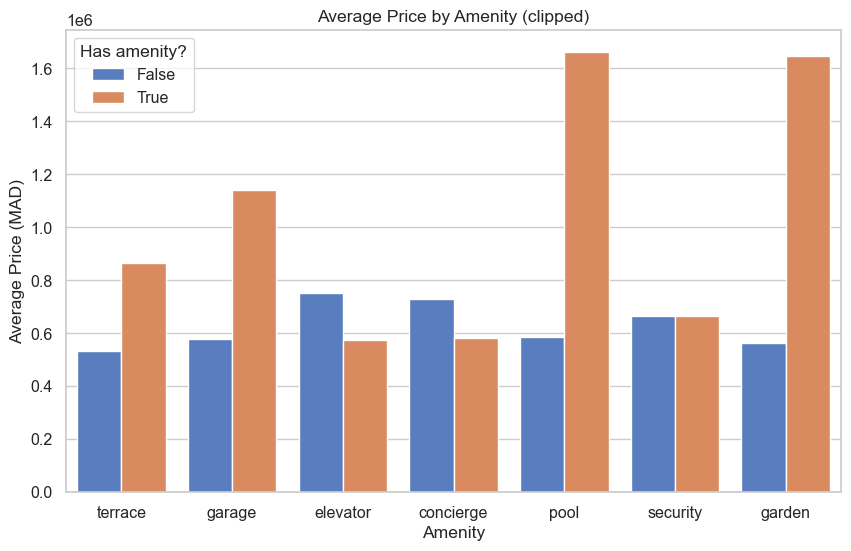

In [24]:
amenities = [c for c in ["terrace","garage","elevator","concierge","pool","security","garden"] if c in df.columns]

avg_prices = []
for col in amenities:
    grp = df.groupby(col, dropna=False)["_price_clip"].mean()
    # ensure we always have True/False columns in the same order when present
    avg_prices.append(pd.DataFrame({"amenity": col, "value": grp.index.astype(str), "avg_price": grp.values}))
amen_df = pd.concat(avg_prices, ignore_index=True) if avg_prices else pd.DataFrame(columns=["amenity","value","avg_price"])

if not amen_df.empty:
    plt.figure(figsize=(10,6))
    sns.barplot(data=amen_df, x="amenity", y="avg_price", hue="value")
    plt.title("Average Price by Amenity (clipped)")
    plt.xlabel("Amenity")
    plt.ylabel("Average Price (MAD)")
    plt.legend(title="Has amenity?")
    plt.show()
else:
    print("No amenity columns available for this analysis.")


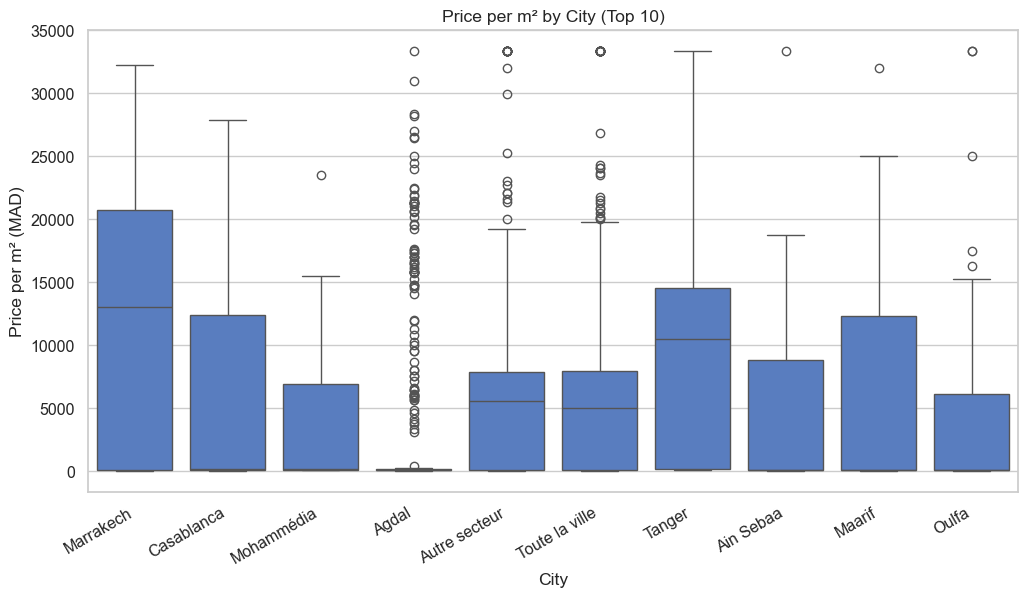

In [18]:
if "price_per_m2" in df.columns and "city" in df.columns:
    subset = df[df["city"].notna()].copy()
    subset["_ppm2_clip"] = clip_series(subset["price_per_m2"])
    top_cities = subset["city"].value_counts().head(10).index
    sub2 = subset[subset["city"].isin(top_cities)]

    plt.figure(figsize=(12,6))
    sns.boxplot(data=sub2, x="city", y="_ppm2_clip")
    plt.title("Price per m² by City (Top 10)")
    plt.xlabel("City")
    plt.ylabel("Price per m² (MAD)")
    plt.xticks(rotation=30, ha="right")
    plt.show()


In [19]:
# Average price by city
if "city" in df.columns:
    city_stats = (
        df.groupby("city")
          .agg(listings=("id","count"),
               avg_price=("_price_clip","mean"),
               median_price=("_price_clip","median"),
               avg_ppm2=("price_per_m2","mean"))
          .sort_values("avg_price", ascending=False)
    )
    city_stats.to_csv("eda_city_stats.csv", index=True)
    print("Saved: eda_city_stats.csv")

# Amenity lift (difference between True vs False)
def amenity_lift(col):
    sub = df[df[col].notna()]
    if sub.empty: return None
    g = sub.groupby(col)["_price_clip"].mean()
    if set(g.index) == {False, True}:
        return float(g[True] - g[False])
    return None

summary = []
for col in amenities:
    lift = amenity_lift(col)
    if lift is not None:
        summary.append({"amenity": col, "avg_price_lift_true_minus_false": lift})
amenity_summary = pd.DataFrame(summary).sort_values("avg_price_lift_true_minus_false", ascending=False)
if not amenity_summary.empty:
    amenity_summary.to_csv("eda_amenity_lift.csv", index=False)
    print("Saved: eda_amenity_lift.csv")
amenity_summary.head(10)


Saved: eda_city_stats.csv
Saved: eda_amenity_lift.csv


,amenity,avg_price_lift_true_minus_false
6,garden,1.083164e+06
4,pool,1.074652e+06
1,garage,5.622130e+05
0,terrace,3.301247e+05
5,security,-2.661083e+03
3,concierge,-1.479845e+05
2,elevator,-1.767683e+05
7,is_furnished,-6.391672e+05
